In [20]:
import numpy as np

# Problem Setup

In [21]:
# Define the Cliff Walking environment parameters
GRID_HEIGHT = 4
GRID_WIDTH = 4
START_STATE = (0, 0)
GOAL_STATE = (3, 3)
CLIFF_ONE = (1, 1)
CLIFF_TWO = (2, 2)

In [22]:
# Actions: 0: Up, 1: Down, 2: Left, 3: Right # nothing
ACTIONS = [( -1, 0), (1, 0), (0, -1), (0, 1), (0, 0)] # delta_row, delta_col
NUM_ACTIONS = len(ACTIONS)

In [23]:
# Rewards
REWARD_NORMAL = -1
REWARD_GOAL = 10
REWARD_CLIFF = -5

# Policy Iteration

In [24]:
def is_valid_state(state):
    row, col = state
    return 0 <= row < GRID_HEIGHT and 0 <= col < GRID_WIDTH

In [25]:
def get_next_state_and_reward(state, action_idx):
    row, col = state
    delta_row, delta_col = ACTIONS[action_idx]
    next_row, next_col = row + delta_row, col + delta_col

    if not is_valid_state((next_row, next_col)):
        # Stay in the same state if moving out of bounds
        next_state = state
        reward = REWARD_NORMAL
    elif (next_row, next_col) == CLIFF_ONE or (next_row, next_col) == CLIFF_TWO:
        # Fell off the cliff
        next_state = START_STATE
        reward = REWARD_CLIFF + REWARD_NORMAL  # -1 for the step, plus cliff penalty
    elif (next_row, next_col) == GOAL_STATE:
        # Reached the goal
        next_state = GOAL_STATE # Stays at goal after reaching
        reward = REWARD_NORMAL # Still -1 per step, but episode ends
    else:
        # Normal movement
        next_state = (next_row, next_col)
        reward = REWARD_NORMAL
    return next_state, reward

In [26]:
def policy_evaluation(policy, gamma=0.9, theta=1e-6):
    """
    Performs iterative policy evaluation to estimate the state-value function V.
    Args:
        policy (dict): A dictionary mapping state to action probabilities (or a single action if deterministic).
        gamma (float): Discount factor.
        theta (float): Threshold for convergence.
    Returns:
        numpy.ndarray: The estimated state-value function V.
    """
    V = np.zeros((GRID_HEIGHT, GRID_WIDTH))

    # define the goal state reward
    V[GOAL_STATE] = REWARD_GOAL


    while True:
        delta = 0
        for r in range(GRID_HEIGHT):
            for c in range(GRID_WIDTH):
                state = (r, c)
                if state == GOAL_STATE:
                    continue # Skip goal state as its value is already set

                v = V[r, c]
                new_v = 0

                # If policy is deterministic (maps state to a single action index)
                action_idx = policy[state]
                next_state, reward = get_next_state_and_reward(state, action_idx)
                new_v += reward + gamma * V[next_state]
            

                V[r, c] = new_v
                delta = max(delta, abs(v - new_v))
        if delta < theta:
            break
    return V

In [32]:
# Example usage:
# Define a simple policy (e.g., always move Right unless at the edge)
# This is a deterministic policy for demonstration
deterministic_policy = {}
for r in range(GRID_HEIGHT):
    for c in range(GRID_WIDTH):
        state = (r, c)
        if state == CLIFF_ONE or state == CLIFF_TWO:
            deterministic_policy[state] = 4
        elif state == GOAL_STATE:
            deterministic_policy[state] = 0 # Action doesn't matter at goal
        elif c < GRID_WIDTH - 1:
            deterministic_policy[state] = 3 # Move Right
        else:
            deterministic_policy[state] = 1 # Move Down (if at right edge)

In [33]:
deterministic_policy

{(0, 0): 3,
 (0, 1): 3,
 (0, 2): 3,
 (0, 3): 1,
 (1, 0): 3,
 (1, 1): 4,
 (1, 2): 3,
 (1, 3): 1,
 (2, 0): 3,
 (2, 1): 3,
 (2, 2): 4,
 (2, 3): 1,
 (3, 0): 3,
 (3, 1): 3,
 (3, 2): 3,
 (3, 3): 0}

In [34]:
# Evaluate the policy
estimated_V = policy_evaluation(deterministic_policy)

print("Estimated State-Value Function (V):")
print(estimated_V)

Estimated State-Value Function (V):
[[ 0.62882    1.8098     3.122      4.58     ]
 [-5.434062  -5.434062   4.58       6.2      ]
 [-5.8906558 -5.434062  -5.434062   8.       ]
 [ 4.58       6.2        8.        10.       ]]


### function to plot the grid world policy

In [35]:
import matplotlib.pyplot as plt

def show_policy(policy, title):
    # Visualize policy
    fig, ax = plt.subplots(1, 1, figsize=(8, 4))
    
    # Create a background grid for visualization
    background = np.zeros((GRID_HEIGHT, GRID_WIDTH))
    ax.imshow(background, cmap='RdYlGn', vmin=-5, vmax=10, alpha=0.3)
    
    # Add grid lines
    for i in range(GRID_HEIGHT + 1):
        ax.axhline(i - 0.5, color='black', linewidth=1)
    for j in range(GRID_WIDTH + 1):
        ax.axvline(j - 0.5, color='black', linewidth=1)
    
    # Show policy arrows
    action_symbols = {0: '↑', 1: '↓', 2: '←', 3: '→', 4: ' '}
    for row in range(GRID_HEIGHT):
        for col in range(GRID_WIDTH):
            state = (row, col)
            if state != GOAL_STATE:
                action = policy[state]
                symbol = action_symbols[action]
                size = 100
                color = 'red'
                ax.text(col, row, symbol, ha='center', va='center', 
                        fontsize=size//3, weight='bold', color=color)
    
    ax.set_title(title, fontsize=14, weight='bold')
    
    # Remove axes as requested
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis('off')
    
    plt.tight_layout()
    plt.show()

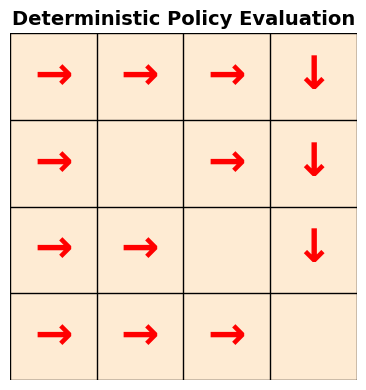

In [36]:
show_policy(deterministic_policy, "Deterministic Policy Evaluation")

### function to plot the value function of the policy

In [37]:
import matplotlib.pyplot as plt

def show_value_function(V, title):
    # Visualize value function
    fig, ax = plt.subplots(1, 1, figsize=(8, 4))
    
    # Create a background grid for visualization
    background = np.zeros((GRID_HEIGHT, GRID_WIDTH))
    ax.imshow(background, cmap='RdYlGn', vmin=-5, vmax=10, alpha=0.3)
    
    # Add grid lines
    for i in range(GRID_HEIGHT + 1):
        ax.axhline(i - 0.5, color='black', linewidth=1)
    for j in range(GRID_WIDTH + 1):
        ax.axvline(j - 0.5, color='black', linewidth=1)
    
    # Show value function as text
    for row in range(GRID_HEIGHT):
        for col in range(GRID_WIDTH):
            state = (row, col)
            value = V[state]
            ax.text(col, row, f"{value:.2f}", ha='center', va='center', 
                    fontsize=12, weight='bold', color='blue')
    
    ax.set_title(title, fontsize=14, weight='bold')
    
    # Remove axes as requested
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis('off')
    
    plt.tight_layout()
    plt.show()

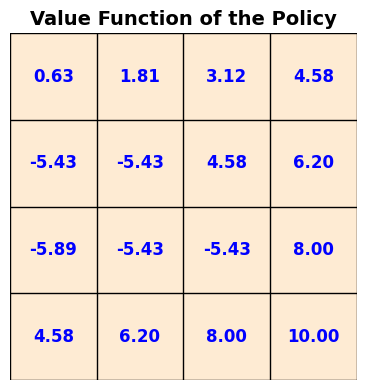

In [38]:
v_test = policy_evaluation(deterministic_policy)
show_value_function(v_test, "Value Function of the Policy")

### function to improve the policy based on the value function (greedy policy improvement)

In [45]:
def greedy_policy_improvement(V, gamma=0.9):
    """
    Performs policy improvement based on the current value function V.
    Args:
        V (numpy.ndarray): The current state-value function.
        gamma (float): Discount factor.
    Returns:
        dict: A new policy mapping states to action indices.
    """
    new_policy = {}
    
    for r in range(GRID_HEIGHT):
        for c in range(GRID_WIDTH):
            state = (r, c)
            if state == GOAL_STATE:
                new_policy[state] = 0 # Action doesn't matter at goal
                continue
            if state == CLIFF_ONE or state == CLIFF_TWO:
                new_policy[state] = 4 # Stay in the same state if on the cliff
                continue
            
            best_action = None
            best_value = float('-inf')
            
            for action_idx in range(NUM_ACTIONS):
                next_state, reward = get_next_state_and_reward(state, action_idx)
                value = reward + gamma * V[next_state]
                
                if value > best_value:
                    best_value = value
                    best_action = action_idx
            
            new_policy[state] = best_action
    
    return new_policy

In [46]:
v_test

array([[ 0.62882  ,  1.8098   ,  3.122    ,  4.58     ],
       [-5.434062 , -5.434062 ,  4.58     ,  6.2      ],
       [-5.8906558, -5.434062 , -5.434062 ,  8.       ],
       [ 4.58     ,  6.2      ,  8.       , 10.       ]])

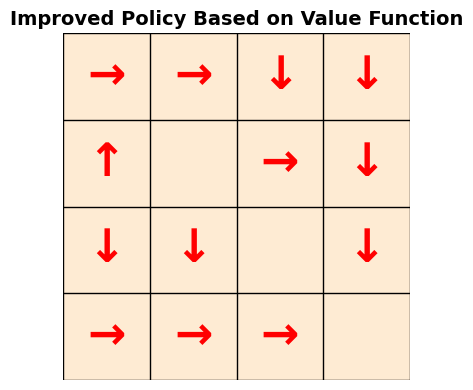

In [47]:
# show improved policy
improved_policy = greedy_policy_improvement(v_test)
show_policy(improved_policy, "Improved Policy Based on Value Function")

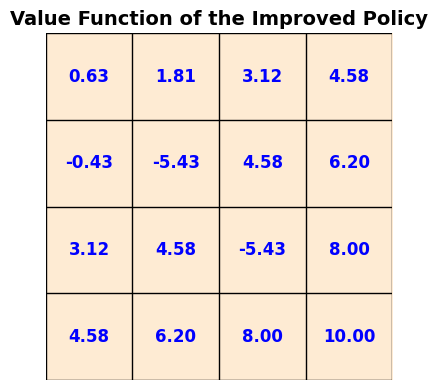

In [49]:
evaluated_policy = policy_evaluation(improved_policy)
show_value_function(evaluated_policy, "Value Function of the Improved Policy")

### Policy Iteration

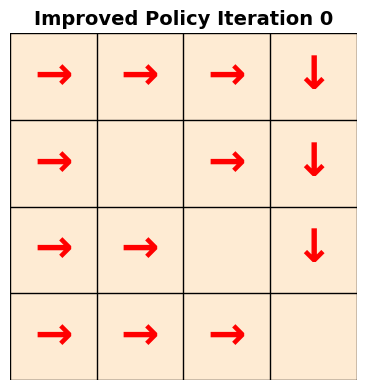

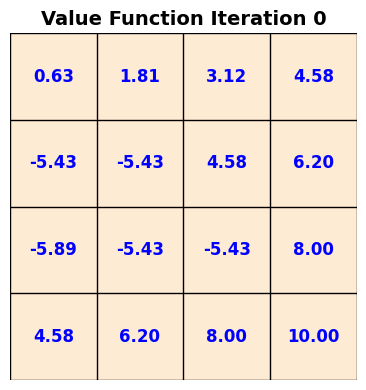

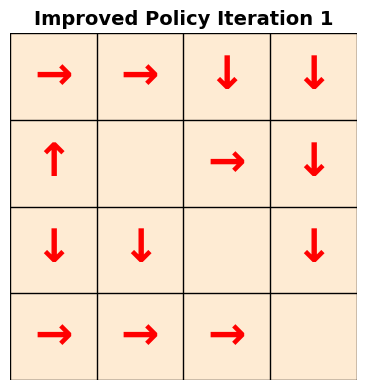

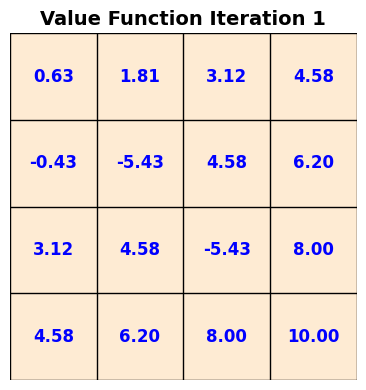

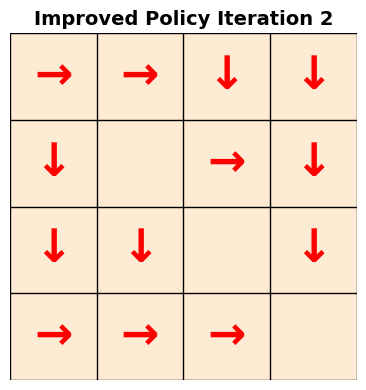

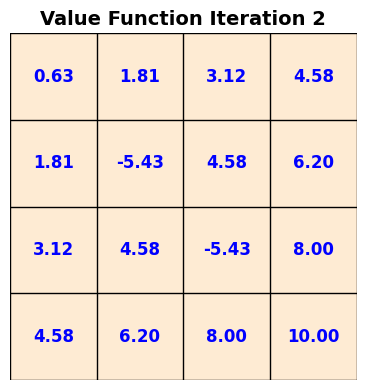

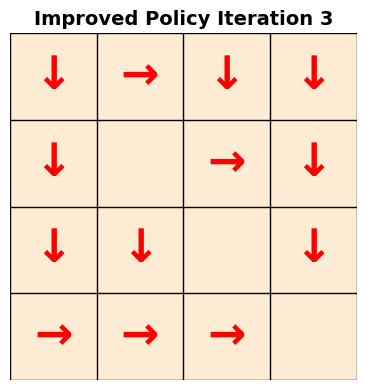

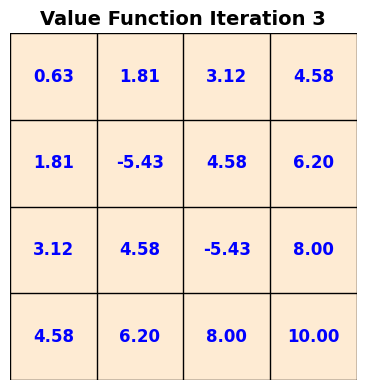

In [50]:
starting_policy = deterministic_policy
improved_policy = starting_policy

for i in range(4):  # Run for a fixed number of iterations
    v = policy_evaluation(improved_policy)
    # Show the improved policy
    show_policy(improved_policy, f"Improved Policy Iteration {i}")
    # Show the value function of the current policy
    show_value_function(v, f"Value Function Iteration {i}")
    # line breaks
    print("\n" + "="*50 + "\n")
    improved_policy = greedy_policy_improvement(v)


# Value Iteration

In [51]:
def value_iteration(gamma=0.9, theta=1e-6, max_iterations=8):
    """
    Performs value iteration to find the optimal value function and policy.
    Args:
        gamma (float): Discount factor.
        theta (float): Threshold for convergence.
        max_iterations (int): Maximum number of iterations to prevent infinite loops.
    Returns:
        tuple: (V, policy) where V is the optimal value function and policy is the optimal policy.
    """
    V = np.zeros((GRID_HEIGHT, GRID_WIDTH))
    
    # Set goal state value
    V[GOAL_STATE] = REWARD_GOAL
    
    for iteration in range(max_iterations):

        V_new = V.copy()
        
        for r in range(GRID_HEIGHT):
            for c in range(GRID_WIDTH):
                state = (r, c)
                if state == GOAL_STATE:
                    continue  # Skip goal state as its value is already set
                
                v = V[r, c]
                
                # Find the maximum value over all possible actions
                max_value = float('-inf')
                for action_idx in range(NUM_ACTIONS):
                    next_state, reward = get_next_state_and_reward(state, action_idx)
                    value = reward + gamma * V[next_state]
                    max_value = max(max_value, value)
                
                V_new[r, c] = max_value
        
        V = V_new
    
    # Extract the optimal policy from the optimal value function
    optimal_policy = {}
    for r in range(GRID_HEIGHT):
        for c in range(GRID_WIDTH):
            state = (r, c)
            if state == GOAL_STATE:
                optimal_policy[state] = 0  # Action doesn't matter at goal
                continue
            if state == CLIFF_ONE or state == CLIFF_TWO:
                optimal_policy[state] = 4 # Stay in the same state if on the cliff
                continue
            
            best_action = None
            best_value = float('-inf')
            
            for action_idx in range(NUM_ACTIONS):
                next_state, reward = get_next_state_and_reward(state, action_idx)
                value = reward + gamma * V[next_state]
                
                if value > best_value:
                    best_value = value
                    best_action = action_idx
            
            optimal_policy[state] = best_action
    
    return V, optimal_policy

In [52]:
# Run value iteration
print("Running Value Iteration...")
optimal_V, optimal_policy = value_iteration()

Running Value Iteration...


In [53]:
# Display results
print("\nOptimal Value Function:")
print(optimal_V)


Optimal Value Function:
[[ 0.62882  1.8098   3.122    4.58   ]
 [ 1.8098   3.122    4.58     6.2    ]
 [ 3.122    4.58     6.2      8.     ]
 [ 4.58     6.2      8.      10.     ]]


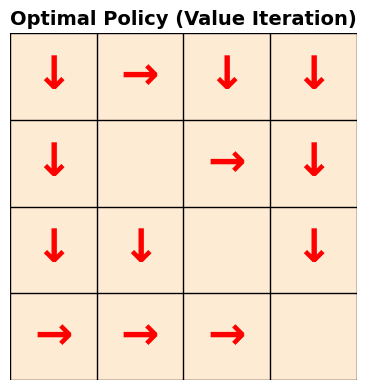

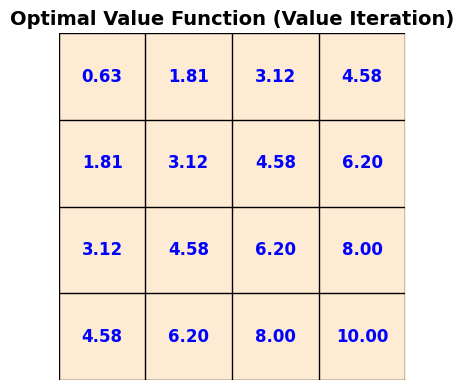

In [54]:
# Visualize the optimal policy
show_policy(optimal_policy, "Optimal Policy (Value Iteration)")

# Visualize the optimal value function
show_value_function(optimal_V, "Optimal Value Function (Value Iteration)")



Running Value Iteration with Visualization...


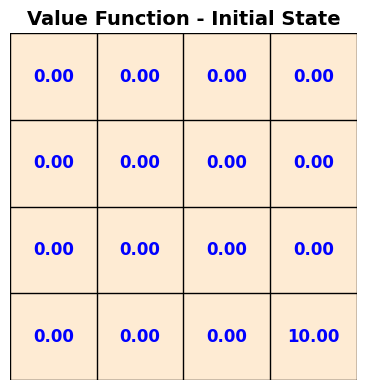

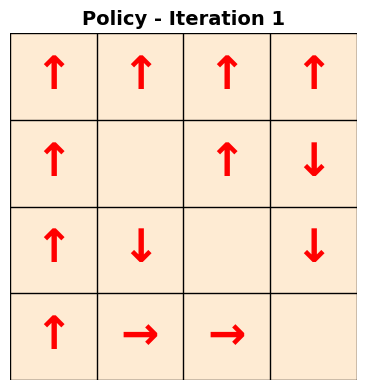

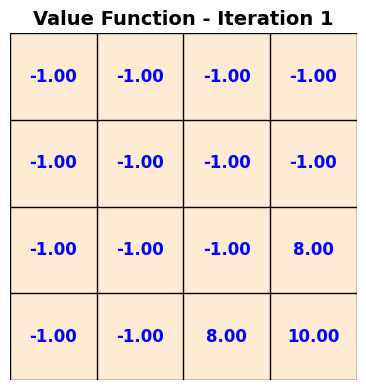

Iteration 1


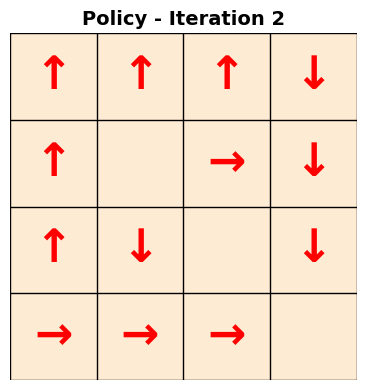

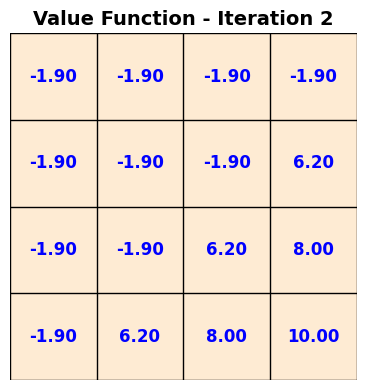

Iteration 2


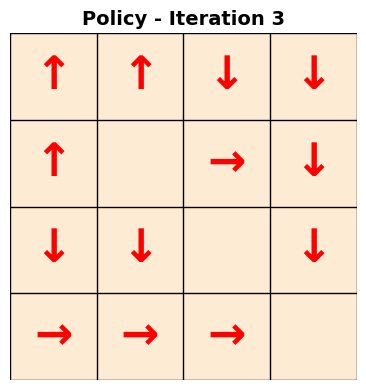

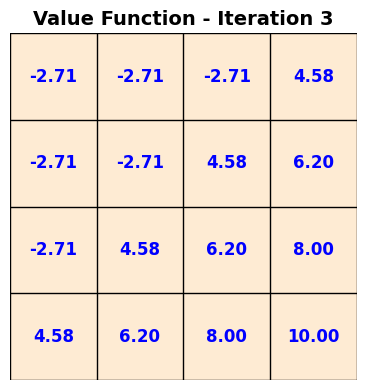

Iteration 3


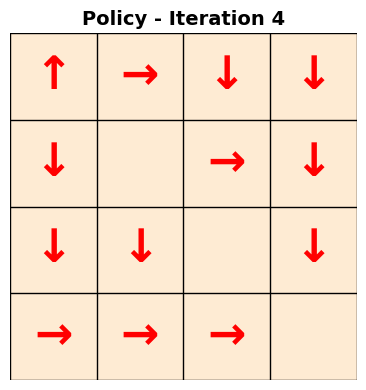

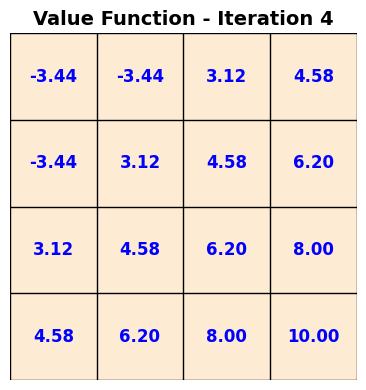

Iteration 4


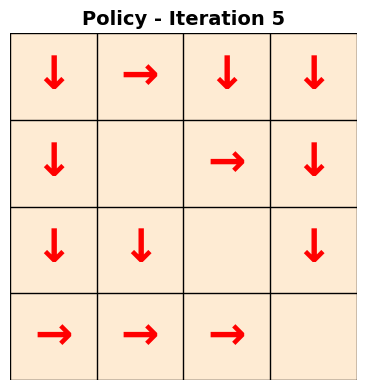

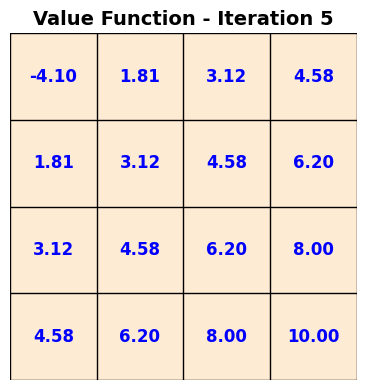

Iteration 5


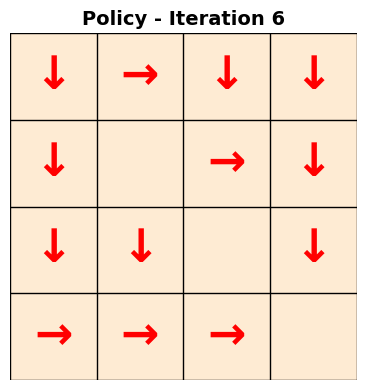

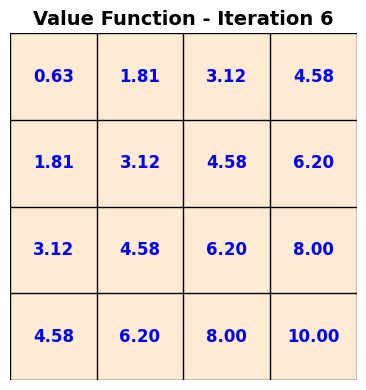

Iteration 6


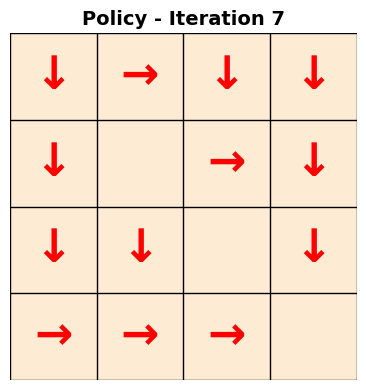

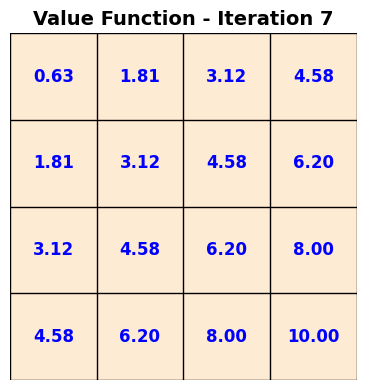

Iteration 7


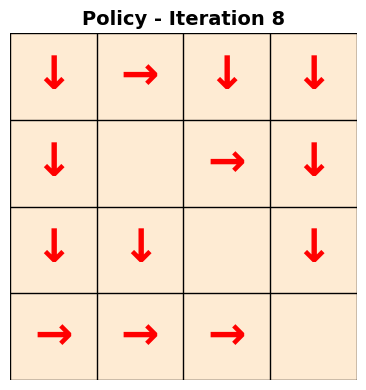

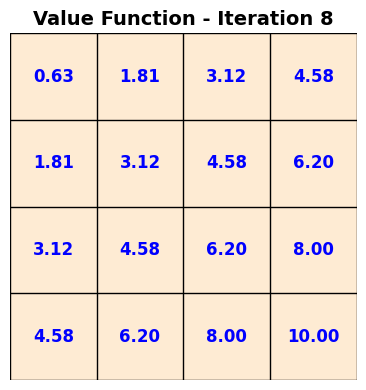

Iteration 8


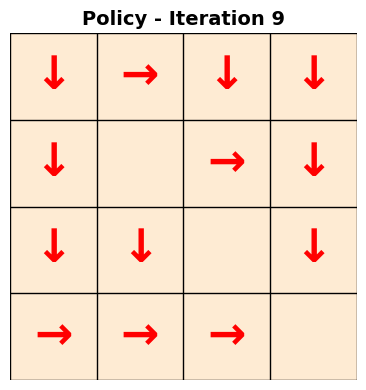

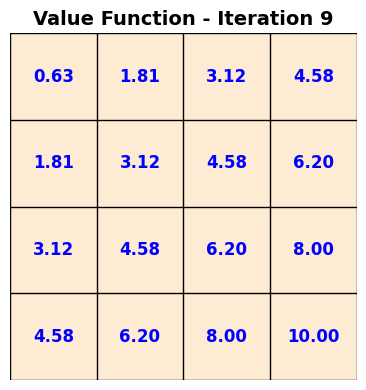

Iteration 9


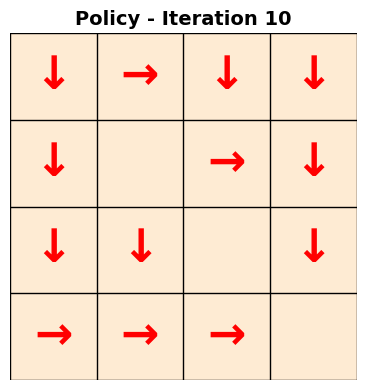

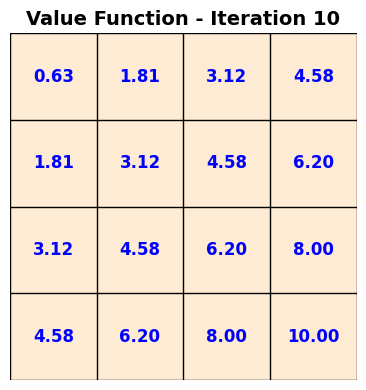

Iteration 10


In [59]:
# Optional: Show convergence by running value iteration with visualization
def value_iteration_with_visualization(gamma=0.9, theta=1e-6, max_iterations=10):
    """
    Performs value iteration with step-by-step visualization.
    """
    V = np.zeros((GRID_HEIGHT, GRID_WIDTH))
    V[GOAL_STATE] = REWARD_GOAL
    
    # Show initial state
    show_value_function(V, "Value Function - Initial State")
    
    for iteration in range(max_iterations):
        V_new = V.copy()
        
        for r in range(GRID_HEIGHT):
            for c in range(GRID_WIDTH):
                state = (r, c)
                if state == GOAL_STATE:
                    continue
                
                v = V[r, c]
                
                # Find the maximum value over all possible actions
                max_value = float('-inf')
                for action_idx in range(NUM_ACTIONS):
                    next_state, reward = get_next_state_and_reward(state, action_idx)
                    value = reward + gamma * V[next_state]
                    max_value = max(max_value, value)
                
                V_new[r, c] = max_value
        
        V = V_new
        
        # Extract current policy
        current_policy = {}
        for r in range(GRID_HEIGHT):
            for c in range(GRID_WIDTH):
                state = (r, c)
                if state == GOAL_STATE:
                    current_policy[state] = 0
                    continue
                if state == CLIFF_ONE or state == CLIFF_TWO:
                    current_policy[state] = 4
                    continue
                
                best_action = None
                best_value = float('-inf')
                
                for action_idx in range(NUM_ACTIONS):
                    next_state, reward = get_next_state_and_reward(state, action_idx)
                    value = reward + gamma * V[next_state]
                    
                    if value > best_value:
                        best_value = value
                        best_action = action_idx
                
                current_policy[state] = best_action
        
        # Show current state
        show_policy(current_policy, f"Policy - Iteration {iteration + 1}")
        show_value_function(V, f"Value Function - Iteration {iteration + 1}")
        
        print(f"Iteration {iteration + 1}")
        print("=" * 50)
    
    return V, current_policy


# Run value iteration with visualization
print("\n\nRunning Value Iteration with Visualization...")
final_V, final_policy = value_iteration_with_visualization()